In [1]:
import numpy as np
import pandas as pd
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
df = pd.read_csv('dc.csv')

In [3]:
df.head()

,Unnamed: 0,open_SAR,open_USD,high_SAR,high_USD,low_SAR,low_USD,close_SAR,close_USD,volume
0,2021-01-30,128437.248512,34246.28,131012.723200,34933.00,123106.880000,32825.00,128333.212416,34218.54,43072
1,2021-01-29,125144.022272,33368.18,144510.037760,38531.90,119695.516160,31915.40,128459.450880,34252.20,231827
2,2021-01-28,113870.357376,30362.19,126703.438592,33783.98,111919.811840,29842.10,125131.570944,33364.86,92621
3,2021-01-27,121753.023104,32464.01,122102.860416,32557.29,109668.146688,29241.72,113885.208960,30366.15,95911
4,2021-01-26,120966.114176,32254.19,123470.218752,32921.88,115652.472448,30837.37,121767.124608,32467.77,84972


In [4]:
df = df.drop(columns=["open_USD", "high_SAR", "high_USD", "low_SAR", "low_USD", "close_SAR", "close_USD", "volume"])

In [5]:
df.head()

,Unnamed: 0,open_SAR
0,2021-01-30,128437.248512
1,2021-01-29,125144.022272
2,2021-01-28,113870.357376
3,2021-01-27,121753.023104
4,2021-01-26,120966.114176


In [6]:
df.columns = ['date', 'open_SAR']

In [7]:
df.head()

,date,open_SAR
0,2021-01-30,128437.248512
1,2021-01-29,125144.022272
2,2021-01-28,113870.357376
3,2021-01-27,121753.023104
4,2021-01-26,120966.114176


In [8]:
len(df)

1000

In [9]:
df.isnull().sum()

date        0
open_SAR    0
dtype: int64

In [22]:
dates = df['date'].values
open_sar = df['open_SAR'].values

In [24]:
mae_val = 0.1*(max(open_sar)-min(open_sar))

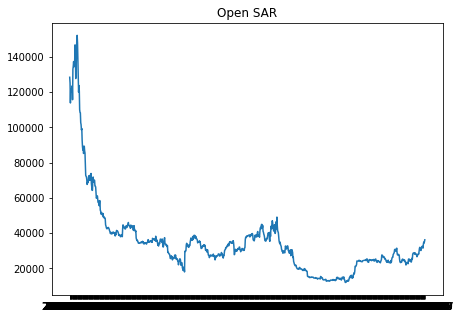

In [26]:
plt.figure(figsize=(7,5))
plt.plot(dates, open_sar)
plt.title('Open SAR',
          fontsize=12);

In [27]:
from sklearn.model_selection import train_test_split
data_latih, data_test, label_latih, label_test = train_test_split(open_sar, dates, test_size=0.2)

In [28]:
len(data_latih)

800

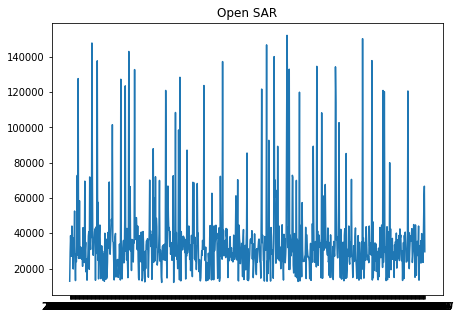

In [29]:
plt.figure(figsize=(7,5))
plt.plot(label_latih, data_latih)
plt.title('Open SAR',
          fontsize=12);

In [30]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

In [31]:
train_set = windowed_dataset(data_latih, window_size=60, batch_size=100, shuffle_buffer=1000)
model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
])

In [32]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('mae')<mae_val):
      print("\nMAE < 10%")
      self.model.stop_training = True
callbacks = myCallback()

In [33]:
optimizer = tf.keras.optimizers.SGD(lr=1.0000e-04, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=100, callbacks=callbacks)

Epoch 1/100
8/8 [==============================] - 5s 92ms/step - loss: 34754.7817 - mae: 34755.2782
Epoch 2/100
8/8 [==============================] - 1s 89ms/step - loss: 35454.8090 - mae: 35455.3086
Epoch 3/100
8/8 [==============================] - 1s 90ms/step - loss: 35136.6628 - mae: 35137.1628
Epoch 4/100
8/8 [==============================] - 1s 88ms/step - loss: 36041.1380 - mae: 36041.6363
Epoch 5/100
8/8 [==============================] - 1s 86ms/step - loss: 34476.0560 - mae: 34476.5560
Epoch 6/100
8/8 [==============================] - 1s 87ms/step - loss: 35798.6029 - mae: 35799.1029
Epoch 7/100
8/8 [==============================] - 1s 88ms/step - loss: 35737.2713 - mae: 35737.7743
Epoch 8/100
8/8 [==============================] - 1s 87ms/step - loss: 34719.9457 - mae: 34720.4470
Epoch 9/100
8/8 [==============================] - 1s 86ms/step - loss: 35515.1775 - mae: 35515.6775
Epoch 10/100
8/8 [==============================] - 1s 87ms/step - loss: 36187.4227 - mae: 